# Financial News Sentiment Analysis - BERT
In this notebook, we will perform sentiment analysis on financial news. The outputs will be classified as positive, negative, or neutral.

In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import pickle
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from tqdm import tqdm

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: Tesla T4


## Loading and Exploring the Dataset

In [3]:
# Load the dataset
df = pd.read_csv('./data/sentiment_data.csv', header=None, names=['text', 'sentiment'])

print("Initial dataset size:", len(df))
df.head()

Initial dataset size: 5843


,text,sentiment
0,Sentence,Sentiment
1,The GeoSolutions technology will leverage Bene...,positive
2,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
3,"For the last quarter of 2010 , Componenta 's n...",positive
4,According to the Finnish-Russian Chamber of Co...,neutral


In [4]:
# Remove duplicate entries based on text
duplicate_count = df.duplicated(subset=['text']).sum()
if duplicate_count > 0:
    print(f"Removing {duplicate_count} duplicate records")
    df = df.drop_duplicates(subset=['text'], keep='first')
    print("Dataset size after removing duplicates:", len(df))

Removing 520 duplicate records
Dataset size after removing duplicates: 5323


In [5]:
# Data cleaning and encoding: map sentiment labels directly to numeric values
def encode_sentiment(s):
    """
    Encode sentiment labels to numeric values for model training.

    Args:
        s (str): Input sentiment label

    Returns:
        int: Encoded sentiment value
            - 2: negative
            - 1: positive
            - 0: neutral
            - None: unknown values
    """
    s = str(s).lower().strip()
    if s in ['negative', 'neg', '-1']:
        return 2  # negative -> 2
    elif s in ['neutral', 'neu', '0']:
        return 0  # neutral -> 0
    elif s in ['positive', 'pos', '1']:
        return 1  # positive -> 1
    else:
        return None  # for unknown values

In [6]:
# Store the mapping for reference
sentiment_mapping = {
    'negative': 2,
    'neutral': 0,
    'positive': 1
}
print("\nSentiment Label Mapping:")
for sentiment, code in sentiment_mapping.items():
    print(f"{sentiment} -> {code}")


Sentiment Label Mapping:
negative -> 2
neutral -> 0
positive -> 1


## 2. Data Preparation for BERT

We will use the previously prepared data for the BERT model. The train-test split has already been performed.

In [7]:
# Load fresh data for BERT (without preprocessing)
# BERT will perform its own tokenization and doesn't need traditional preprocessing
df_bert = pd.read_csv('./data/sentiment_data.csv', header=None, names=['text', 'sentiment'])

# Remove duplicates
df_bert = df_bert.drop_duplicates(subset=['text'], keep='first')

# Encode sentiment labels
df_bert['sentiment_encoded'] = df_bert['sentiment'].apply(encode_sentiment)
df_bert = df_bert.dropna(subset=['sentiment_encoded'])
df_bert['sentiment_encoded'] = df_bert['sentiment_encoded'].astype(int)

print(f"BERT dataset size: {len(df_bert)}")
print(f"Sentiment distribution:\n{df_bert['sentiment_encoded'].value_counts().sort_index()}")

# Split data for BERT
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(
    df_bert['text'].values,
    df_bert['sentiment_encoded'].values,
    test_size=0.2,
    random_state=9,
    stratify=df_bert['sentiment_encoded']
)

print(f"\nBERT Training set: {len(X_train_bert)} samples")
print(f"BERT Test set: {len(X_test_bert)} samples")

BERT dataset size: 5322
Sentiment distribution:
sentiment_encoded
0    2878
1    1852
2     592
Name: count, dtype: int64

BERT Training set: 4257 samples
BERT Test set: 1065 samples


## 3. BERT Tokenizer and Dataset Creation

In [8]:
# Load BERT tokenizer
# MODEL_NAME = 'bert-base-uncased'  # General purpose BERT
MODEL_NAME = 'ProsusAI/finbert'  # Financial domain-specific (alternative)

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
print(f"Tokenizer loaded: {MODEL_NAME}")

Tokenizer loaded: ProsusAI/finbert


In [9]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        """
        Custom Dataset class for BERT.

        Args:
            texts (array): Text data
            labels (array): Sentiment labels
            tokenizer: BERT tokenizer
            max_length (int): Maximum token length
        """
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize the text
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
MAX_LENGTH = 128

train_dataset = SentimentDataset(
    texts=X_train_bert,
    labels=y_train_bert,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

test_dataset = SentimentDataset(
    texts=X_test_bert,
    labels=y_test_bert,
    tokenizer=tokenizer,
    max_length=MAX_LENGTH
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 4257
Test dataset size: 1065


In [10]:
# Create DataLoaders
BATCH_SIZE = 16

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 267
Test batches: 67


## 4. BERT Model Definition and Training Setup

In [11]:
# Load BERT model
NUM_CLASSES = 3  # neutral, positive, negative

bert_model = BertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=NUM_CLASSES,
    output_attentions=False,
    output_hidden_states=False
)

# Move model to GPU (if available)
bert_model = bert_model.to(device)

print(f"Model loaded and moved to {device}")
print(f"Model parameters: {sum(p.numel() for p in bert_model.parameters()):,}")

Model loaded and moved to cuda
Model parameters: 109,484,547


In [12]:
# Training parameters
EPOCHS = 10
LEARNING_RATE = 2e-5

# Optimizer
optimizer = AdamW(bert_model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Learning rate scheduler
total_steps = len(train_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Loss function
loss_fn = nn.CrossEntropyLoss().to(device)

print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Total training steps: {total_steps}")

Epochs: 10
Learning Rate: 2e-05
Total training steps: 2670


## 5. Training and Evaluation Functions

In [13]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    """
    Train model for one epoch.

    Returns:
        float: Average training loss
        float: Training accuracy
    """
    model.train()
    losses = []
    correct_predictions = 0

    for batch in tqdm(data_loader, desc='Training'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        loss = loss_fn(logits, labels)

        # Predictions
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)

        losses.append(loss.item())

        # Backward pass
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return np.mean(losses), correct_predictions.double() / len(data_loader.dataset)


def eval_model(model, data_loader, loss_fn, device):
    """
    Model evaluation.

    Returns:
        float: Average validation loss
        float: Validation accuracy
        np.array: True labels
        np.array: Predicted labels
    """
    model.eval()
    losses = []
    correct_predictions = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Evaluating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            loss = loss_fn(logits, labels)

            _, preds = torch.max(logits, dim=1)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return (
        np.mean(losses),
        correct_predictions.double() / len(data_loader.dataset),
        np.array(all_labels),
        np.array(all_preds)
    )

print("Training and evaluation functions are ready.")

Training and evaluation functions are ready.


## 6. Model Training

In [14]:
# Training history
history_bert = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_accuracy_bert = 0

for epoch in range(EPOCHS):
    print(f'\nEpoch {epoch + 1}/{EPOCHS}')
    print('-' * 50)

    # Training
    train_loss, train_acc = train_epoch(
        bert_model,
        train_loader,
        loss_fn,
        optimizer,
        device,
        scheduler
    )

    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}')

    # Evaluation
    val_loss, val_acc, _, _ = eval_model(
        bert_model,
        test_loader,
        loss_fn,
        device
    )

    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}')

    # Save history
    history_bert['train_loss'].append(train_loss)
    history_bert['train_acc'].append(train_acc.item())
    history_bert['val_loss'].append(val_loss)
    history_bert['val_acc'].append(val_acc.item())

    # Save best model
    if val_acc > best_accuracy_bert:
        best_accuracy_bert = val_acc
        torch.save(bert_model.state_dict(), './models/bert_sentiment_best.pt')
        print(f'Model saved with accuracy: {best_accuracy_bert:.4f}')

print(f'\nTraining completed! Best accuracy: {best_accuracy_bert:.4f}')


Epoch 1/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [01:33<00:00,  2.87it/s]


Train Loss: 0.6506, Train Accuracy: 0.7242


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.57it/s]


Val Loss: 0.3621, Val Accuracy: 0.8432
Model saved with accuracy: 0.8432

Epoch 2/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [01:31<00:00,  2.91it/s]


Train Loss: 0.2916, Train Accuracy: 0.8863


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.58it/s]


Val Loss: 0.3681, Val Accuracy: 0.8479
Model saved with accuracy: 0.8479

Epoch 3/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [01:31<00:00,  2.91it/s]


Train Loss: 0.1679, Train Accuracy: 0.9345


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.61it/s]


Val Loss: 0.4921, Val Accuracy: 0.8469

Epoch 4/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [01:31<00:00,  2.93it/s]


Train Loss: 0.1097, Train Accuracy: 0.9551


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.62it/s]


Val Loss: 0.5686, Val Accuracy: 0.8676
Model saved with accuracy: 0.8676

Epoch 5/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [01:31<00:00,  2.92it/s]


Train Loss: 0.0780, Train Accuracy: 0.9709


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.64it/s]


Val Loss: 0.6589, Val Accuracy: 0.8545

Epoch 6/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [01:31<00:00,  2.93it/s]


Train Loss: 0.0514, Train Accuracy: 0.9807


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.56it/s]


Val Loss: 0.7057, Val Accuracy: 0.8535

Epoch 7/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [01:31<00:00,  2.93it/s]


Train Loss: 0.0352, Train Accuracy: 0.9878


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.51it/s]


Val Loss: 0.8387, Val Accuracy: 0.8516

Epoch 8/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [01:31<00:00,  2.92it/s]


Train Loss: 0.0253, Train Accuracy: 0.9906


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.52it/s]


Val Loss: 0.8589, Val Accuracy: 0.8460

Epoch 9/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [01:31<00:00,  2.92it/s]


Train Loss: 0.0177, Train Accuracy: 0.9939


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.64it/s]


Val Loss: 0.8648, Val Accuracy: 0.8516

Epoch 10/10
--------------------------------------------------


Training: 100%|██████████| 267/267 [01:31<00:00,  2.93it/s]


Train Loss: 0.0154, Train Accuracy: 0.9965


Evaluating: 100%|██████████| 67/67 [00:07<00:00,  8.56it/s]

Val Loss: 0.8717, Val Accuracy: 0.8535

Training completed! Best accuracy: 0.8676


## 7. Training History Visualization

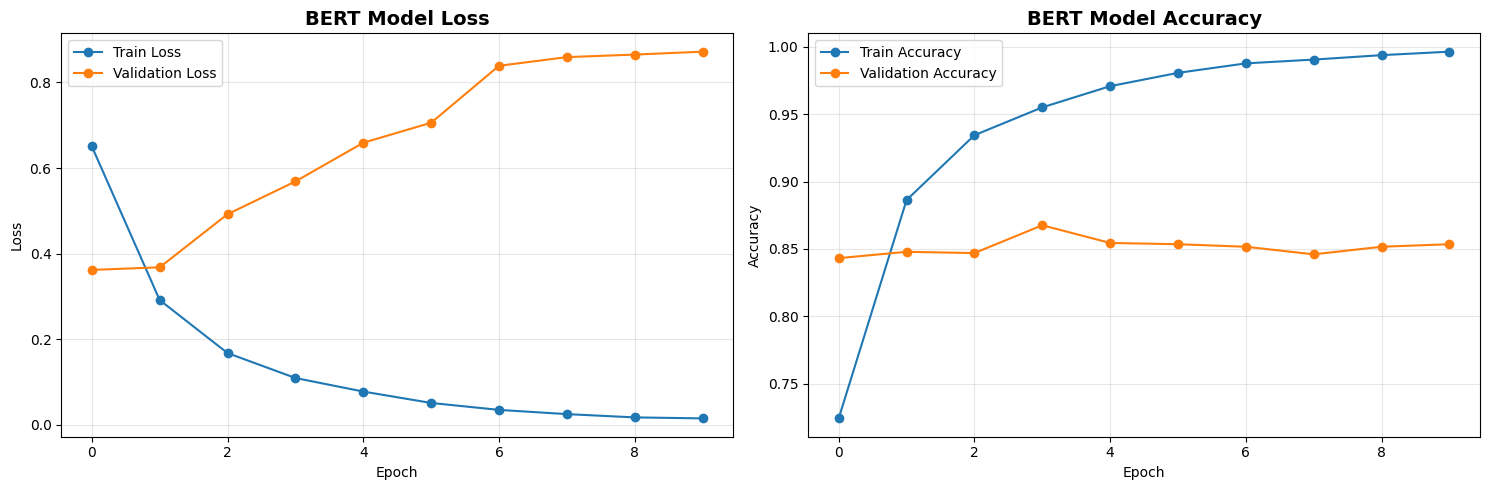

In [15]:
# Loss and Accuracy plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(history_bert['train_loss'], label='Train Loss', marker='o')
ax1.plot(history_bert['val_loss'], label='Validation Loss', marker='o')
ax1.set_title('BERT Model Loss', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(history_bert['train_acc'], label='Train Accuracy', marker='o')
ax2.plot(history_bert['val_acc'], label='Validation Accuracy', marker='o')
ax2.set_title('BERT Model Accuracy', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Final Evaluation on Test Set

In [16]:
# Load the best model
bert_model.load_state_dict(torch.load('./models/bert_sentiment_best.pt'))
print("Best BERT model loaded.")

# Evaluation on test set
test_loss_bert, test_acc_bert, y_true_bert, y_pred_bert = eval_model(
    bert_model,
    test_loader,
    loss_fn,
    device
)

print(f"\nBERT Model Test Results:")
print(f"Test Loss: {test_loss_bert:.4f}")
print(f"Test Accuracy: {test_acc_bert:.4f}")
print(f"Test F1-Score (weighted): {f1_score(y_true_bert, y_pred_bert, average='weighted'):.4f}")

Best BERT model loaded.


Evaluating: 100%|██████████| 67/67 [00:08<00:00,  8.09it/s]


BERT Model Test Results:
Test Loss: 0.5686
Test Accuracy: 0.8676
Test F1-Score (weighted): 0.8654


In [17]:
# Classification Report
sentiment_labels = ['neutral', 'positive', 'negative']
print("\nBERT Classification Report:")
print(classification_report(y_true_bert, y_pred_bert, target_names=sentiment_labels))


BERT Classification Report:
              precision    recall  f1-score   support

     neutral       0.89      0.92      0.91       576
    positive       0.86      0.88      0.87       371
    negative       0.72      0.60      0.65       118

    accuracy                           0.87      1065
   macro avg       0.83      0.80      0.81      1065
weighted avg       0.86      0.87      0.87      1065



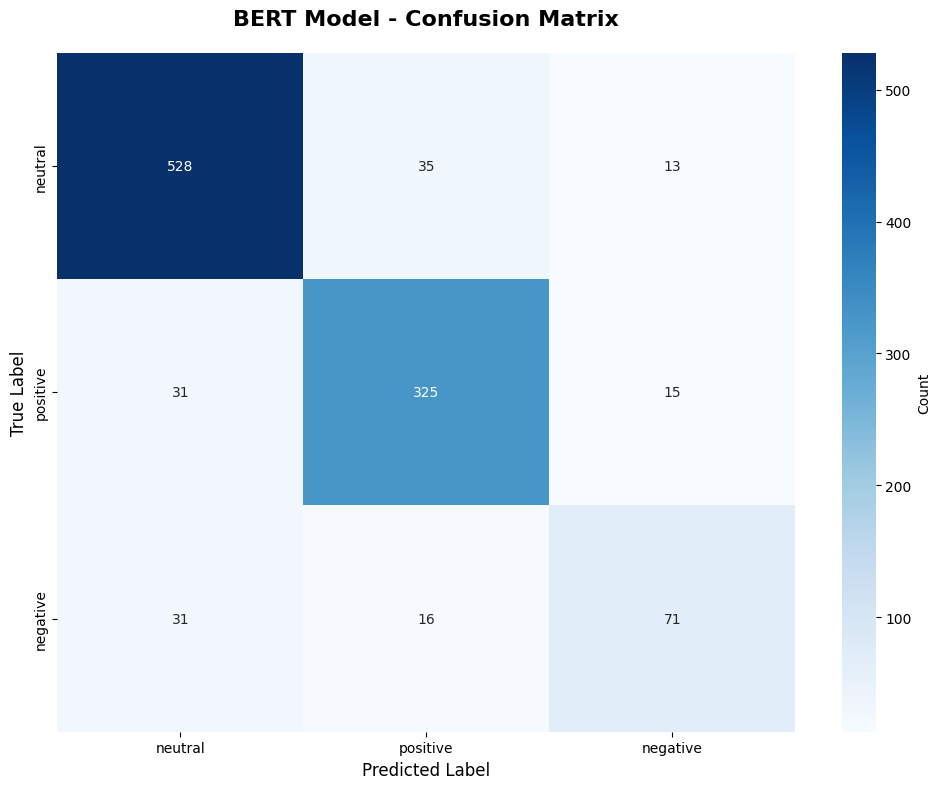


Accuracy for each class:
neutral: 0.9167
positive: 0.8760
negative: 0.6017


In [18]:
# Confusion Matrix
cm_bert = confusion_matrix(y_true_bert, y_pred_bert)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_bert,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=sentiment_labels,
    yticklabels=sentiment_labels,
    cbar_kws={'label': 'Count'}
)
plt.title('BERT Model - Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Calculate accuracy for each class
print("\nAccuracy for each class:")
for i, label in enumerate(sentiment_labels):
    class_accuracy = cm_bert[i, i] / cm_bert[i].sum()
    print(f"{label}: {class_accuracy:.4f}")

## 9. BERT Prediction Function

In [19]:
def predict_sentiment_bert(text, model, tokenizer, device, max_length=128):
    """
    Predict sentiment using BERT model.

    Args:
        text (str): Text to predict
        model: Trained BERT model
        tokenizer: BERT tokenizer
        device: CPU or GPU
        max_length (int): Maximum token length

    Returns:
        dict: Prediction result and probabilities
    """
    model.eval()

    # Tokenize the text
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1)

    sentiment_labels_map = {0: 'neutral', 1: 'positive', 2: 'negative'}
    predicted_sentiment = sentiment_labels_map[prediction.item()]

    probs = probabilities[0].cpu().numpy()

    return {
        'sentiment': predicted_sentiment,
        'confidence': probs[prediction.item()],
        'probabilities': {
            'neutral': probs[0],
            'positive': probs[1],
            'negative': probs[2]
        }
    }

print("BERT prediction function is ready.")

BERT prediction function is ready.


## 10. Test Examples with BERT

In [20]:
# Test texts
test_texts_bert = [
    "Stock market reaches all-time high as tech sector booms",
    "Company announces massive layoffs amid financial troubles",
    "Market remains stable as Fed maintains current interest rates",
    "The company's earnings report exceeded expectations.",
    "Investors are concerned about the declining profit margins",
    "The merger is expected to create significant value for shareholders"
]

print("\n" + "="*80)
print("BERT MODEL SENTIMENT PREDICTIONS")
print("="*80)

for i, text in enumerate(test_texts_bert, 1):
    result = predict_sentiment_bert(text, bert_model, tokenizer, device)

    print(f"\n{i}. Text: {text}")
    print(f"   Predicted Sentiment: {result['sentiment'].upper()}")
    print(f"   Confidence: {result['confidence']:.4f}")
    print(f"   Probabilities:")
    for sentiment, prob in result['probabilities'].items():
        print(f"      {sentiment}: {prob:.4f}")
    print("-" * 80)


BERT MODEL SENTIMENT PREDICTIONS

1. Text: Stock market reaches all-time high as tech sector booms
   Predicted Sentiment: POSITIVE
   Confidence: 0.9966
   Probabilities:
      neutral: 0.0011
      positive: 0.9966
      negative: 0.0023
--------------------------------------------------------------------------------

2. Text: Company announces massive layoffs amid financial troubles
   Predicted Sentiment: NEGATIVE
   Confidence: 0.9931
   Probabilities:
      neutral: 0.0041
      positive: 0.0029
      negative: 0.9931
--------------------------------------------------------------------------------

3. Text: Market remains stable as Fed maintains current interest rates
   Predicted Sentiment: NEUTRAL
   Confidence: 0.6243
   Probabilities:
      neutral: 0.6243
      positive: 0.3739
      negative: 0.0018
--------------------------------------------------------------------------------

4. Text: The company's earnings report exceeded expectations.
   Predicted Sentiment: POSITIVE

## 11. Save BERT Model and Tokenizer

In [21]:
# Save model and tokenizer
bert_model_save_path = './models/bert_model'
os.makedirs(bert_model_save_path, exist_ok=True)

# Save the model
bert_model.save_pretrained(bert_model_save_path)
# Save the tokenizer
tokenizer.save_pretrained(bert_model_save_path)

print(f"\nBERT model and tokenizer saved: {bert_model_save_path}")
print("\nSaved files:")
for file in os.listdir(bert_model_save_path):
    print(f"  - {file}")


BERT model and tokenizer saved: ./models/bert_model

Saved files:
  - tokenizer_config.json
  - config.json
  - model.safetensors
  - special_tokens_map.json
  - vocab.txt


In [22]:
import os

file_path = './models/bert_sentiment_best.pt'

if os.path.exists(file_path):
    file_size_bytes = os.path.getsize(file_path)
    file_size_mb = file_size_bytes / (1024 * 1024) # Convert bytes to MB
    print(f"File size of '{file_path}': {file_size_bytes} bytes ({file_size_mb:.2f} MB)")
else:
    print(f"File '{file_path}' does not exist.")

File size of './models/bert_sentiment_best.pt': 438022689 bytes (417.73 MB)


In [23]:
import os

file_path = '/content/models/bert_model/model.safetensors'

if os.path.exists(file_path):
    file_size_bytes = os.path.getsize(file_path)
    file_size_mb = file_size_bytes / (1024 * 1024) # Convert bytes to MB
    print(f"File size of '{file_path}': {file_size_bytes} bytes ({file_size_mb:.2f} MB)")
else:
    print(f"File '{file_path}' does not exist.")

File size of '/content/models/bert_model/model.safetensors': 437961724 bytes (417.67 MB)


In [25]:
from google.colab import files
import os

file_to_download = '/content/models/bert_model/model.safetensors'

if os.path.exists(file_to_download):
    files.download(file_to_download)
    print(f"'{file_to_download}' downloaded successfully.")
else:
    print(f"File '{file_to_download}' does not exist. Please check the path.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'/content/models/bert_model/model.safetensors' downloaded successfully.
